In this example, we create a sinogram using a Shepp-Logan phantom and use self-supervised CNNs to reconstruct the tomographic image. The following CNNs can be tested: Automap, GANrec and SD2I with/without upsampling layers.

In [1]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import GANrec, SD2I, Automap, Discriminator
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss, discriminator_loss
from nDTomo.utils.misc import cirmask

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

Check if Tensorflow will run on GPU

In [2]:
tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's load the sinogram.

In [3]:
#chose the dataset from ['micro779_ch1', 'micro779_ch2', xrdct_ch1, xrdct_ch2, micro1559_ch1, micro1559_ch2]
dataset_name = 'micro779_ch2'

fn = 'F:/Dropbox (Finden)/Finden team folder/AI/Reconstruction/paper/data/sinograms_used_in_paper.h5'

with h5py.File(fn, 'r') as f:
    print(f.keys())
    sino = np.array(f[dataset_name + '_angsamp'][:])
    sino_full = np.array(f[dataset_name][:])

print('sinogram shape before angular undersampling: ', sino_full.shape)
print('sinogram shape after angular undersampling: ', sino.shape)

<KeysViewHDF5 ['micro1559_ch1', 'micro1559_ch1_angsamp', 'micro1559_ch2', 'micro1559_ch2_angsamp', 'micro779_ch1', 'micro779_ch1_angsamp', 'micro779_ch2', 'micro779_ch2_angsamp', 'xrdct_ch1', 'xrdct_ch1_angsamp', 'xrdct_ch2', 'xrdct_ch2_angsamp']>
sinogram shape before angular undersampling:  (1561, 779)
sinogram shape after angular undersampling:  (223, 779)


Choose reconstruction method.

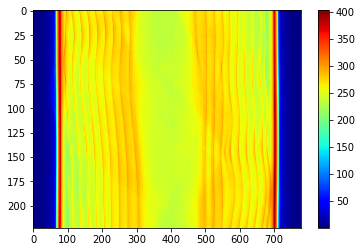

(1, 223, 779)


In [4]:
npix = sino.shape[1] # image size
npr = sino.shape[0] # number of projections

with_disc = False # Use discriminator or not

method = 'SD2Iup' # Choose method from 'SD2Iup', 'SD2I', 'GANrec', 'Automap'

factor = 8 # Used for SD2I methods

theta = np.radians(np.arange(0, 180, 180/sino_full.shape[0]))
theta = theta[::(sino_full.shape[0]//npr)]

pattern_input = sino.reshape([1, npr, npix, 1])
showim(tf_tomo_squeeze(pattern_input), 2)

pattern_input = pattern_input[:,:,:,0]
print(pattern_input.shape)

In [5]:
print(sino_full.shape[0]//npr)

7


Let's create the mask

In [6]:
mask = np.ones((npix, npix))
mask = cirmask(mask,0)

Calculate the reconstructed image using the filtered back projection algorithm

In [7]:
def relufunc(x):
    return (abs(x) + x) / 2

The dimensions of the reconstructed volume are  (779, 779)


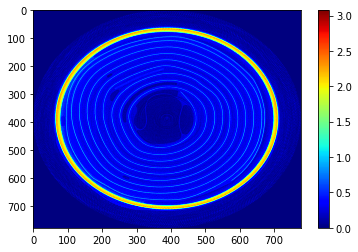

In [8]:
fbp = fbpvol(np.array(pattern_input[0]).transpose(), theta=np.rad2deg(theta), nt = npix)
fbp = relufunc(fbp)
showim(fbp, 3, clim=(0, np.max(fbp)))

Calculate the image without upsampling using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (779, 779)


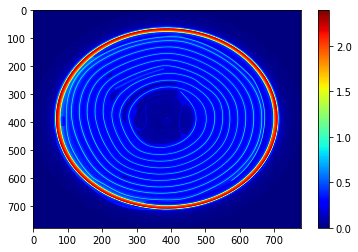

In [9]:
theta_full =  tf_create_angles(sino_full.shape[0])
fbp_full = fbpvol(np.array(sino_full).transpose(), theta=np.rad2deg(theta_full), nt = npix)
fbp_full = relufunc(fbp_full)
showim(fbp_full, 3, clim=(0, np.max(fbp_full)))

Next we prepare the function for training the neural network

Training loop

In [10]:
if not with_disc:
    @tf.function 
    def train_step(input_number, dataset, mask):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
        
            print(generated_img.shape)
            generated_img = generated_img[0,:,:,0] * mask
            
            generated_img = tf.expand_dims(generated_img, 0, name=None)
            generated_img = tf.expand_dims(generated_img, 3, name=None)
            
            pattern_gen = tf_tomo_radon(generated_img, theta)
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            

            dataset = tf.transpose(dataset, [1, 2, 0])
            print(3)
            print(pattern_gen.shape)
            print(dataset.shape)

            matrix_loss = ssim_mae_loss(dataset, pattern_gen)

        grad_gen = tape.gradient(matrix_loss, generator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        return matrix_loss

else:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            print(generated_img.shape)
            generated_img = generated_img[0,:,:,0] * mask
            
            generated_img = tf.expand_dims(generated_img, 0, name=None)
            generated_img = tf.expand_dims(generated_img, 3, name=None)
            
            pattern_gen = tf_tomo_radon(generated_img, theta)
            
            real_output = discriminator(tf.expand_dims(dataset, -1))
            generated_output = discriminator(pattern_gen)
            
            pattern_gen = pattern_gen[0,:,:,0]
            
            pattern_gen = pattern_gen * mask
            
            pattern_gen = tf.expand_dims(pattern_gen, 2, name=None)
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(2)
            print(dataset.shape)
            print(pattern_gen.shape)
            gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                      labels=tf.ones_like(generated_output))) \
                       + ssim_mae_loss(dataset, pattern_gen)

            disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
            disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.zeros_like(generated_output)))
            disc_loss = disc_loss_real+disc_loss_fake

        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)

        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        print(3)
        return gen_loss

Setup the model, optimizers and learning rate

In [11]:
if method == 'SD2Iup':
    generator = SD2I(npix, factor)
elif method == 'SD2I':
    generator = SD2I(npix, factor, upsample=False)
elif method == 'GANrec':
    generator = GANrec(npix, npr)
elif method == 'Automap':
    generator = Automap(npix, npr)
    
if with_disc:
    discriminator = Discriminator(npix, npr)
    disc_optimizer = tf.keras.optimizers.Adam(0.0005)
    
generator.summary()
gen_optimizer = tf.keras.optimizers.Adam(0.0005)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(300/100),
                            factor=0.5,
                            verbose=1, 
                            optim_lr=gen_optimizer.learning_rate, 
                            reduce_lin=True)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 304200)            19773000  
_________________________________________________________________
reshape (Reshape)            (None, 195, 195, 8)      

In [12]:
max_point = np.max(sino)

In [13]:
def ssim_mae_loss(y_true, y_pred):
    return((1-0.87)*tf.reduce_mean(tf.keras.losses.MAE(y_pred, y_true)) + 0.87*(1 - tf.reduce_mean(tf.image.ssim(y_pred, y_true, max_point))))

In [14]:
def ssim_mae_loss(y_true, y_pred):
    return((1-0.87)*tf.reduce_mean(tf.keras.losses.MAE(y_pred, y_true)) + 0.87*(1 - tf.reduce_mean(tf.image.ssim(y_pred, y_true, 2.6))))

Setup the epochs needed and start the training loop.

In [ ]:
epochs = 6000
save_interval = 100

chemct_tf = tf.cast(pattern_input, 'float32')
mask = tf.cast(mask, 'float32')

if method == 'GANrec':
    bp = tf_tomo_bp(chemct_tf, theta)
    input_number = bp
elif method == 'Automap':
    input_number = chemct_tf
else:
    input_number = tf.cast(np.array([1]), 'float32')

start = time.time()
reduce_rl_plateau.on_train_begin()
kk = 1

for epoch in tqdm(range(epochs)):

    loss = train_step(input_number, chemct_tf, mask)

    if epoch % save_interval == 0 and epoch != 0:

        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, (time.time() - start) / save_interval, loss))
        start = time.time()
        plt.close()

        reduce_rl_plateau.on_epoch_end(kk, loss)
        kk += 1


  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

1
(1, 779, 779, 1)


c:\programdata\anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)


3
(223, 779, 1)
(223, 779, 1)
1
(1, 779, 779, 1)
3
(223, 779, 1)
(223, 779, 1)


  2%|█▎                                                                             | 103/6000 [00:17<11:48,  8.32it/s]

Time for epoch 1 to 100 is 0.17320839405059815 sec/it - gen_loss = 1.4378122091293335


  3%|██▋                                                                            | 203/6000 [00:28<09:23, 10.29it/s]

Time for epoch 101 to 200 is 0.10628581285476685 sec/it - gen_loss = 1.3048614263534546


  5%|███▉                                                                           | 303/6000 [00:39<11:34,  8.20it/s]

Time for epoch 201 to 300 is 0.10893868684768676 sec/it - gen_loss = 1.1066269874572754


  7%|█████▎                                                                         | 403/6000 [00:51<09:46,  9.54it/s]

Time for epoch 301 to 400 is 0.12195391416549682 sec/it - gen_loss = 1.1234734058380127


  8%|██████▌                                                                        | 503/6000 [01:02<09:09, 10.01it/s]

Time for epoch 401 to 500 is 0.11017538547515869 sec/it - gen_loss = 1.3805633783340454


 10%|███████▉                                                                       | 603/6000 [01:14<12:18,  7.31it/s]

Time for epoch 501 to 600 is 0.1142844319343567 sec/it - gen_loss = 1.2413935661315918

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


 12%|█████████▎                                                                     | 703/6000 [01:25<09:20,  9.45it/s]

Time for epoch 601 to 700 is 0.11337684392929077 sec/it - gen_loss = 0.7474551796913147


 13%|██████████▌                                                                    | 803/6000 [01:37<09:02,  9.58it/s]

Time for epoch 701 to 800 is 0.11661075830459594 sec/it - gen_loss = 0.6659827828407288


 15%|███████████▊                                                                   | 901/6000 [01:49<14:04,  6.04it/s]

Time for epoch 801 to 900 is 0.12373914003372193 sec/it - gen_loss = 0.6066315770149231


 17%|█████████████                                                                 | 1003/6000 [02:02<08:18, 10.03it/s]

Time for epoch 901 to 1000 is 0.12609486818313598 sec/it - gen_loss = 0.5615749359130859


 18%|██████████████▎                                                               | 1103/6000 [02:14<10:05,  8.09it/s]

Time for epoch 1001 to 1100 is 0.11765843629837036 sec/it - gen_loss = 0.5108416676521301


 20%|███████████████▋                                                              | 1203/6000 [02:26<09:11,  8.69it/s]

Time for epoch 1101 to 1200 is 0.12400642633438111 sec/it - gen_loss = 0.5144520998001099


 22%|████████████████▉                                                             | 1303/6000 [02:39<11:35,  6.76it/s]

Time for epoch 1201 to 1300 is 0.1251621127128601 sec/it - gen_loss = 0.4652174711227417


 23%|██████████████████▏                                                           | 1403/6000 [02:52<08:05,  9.46it/s]

Time for epoch 1301 to 1400 is 0.12733492374420166 sec/it - gen_loss = 0.4425053298473358


 25%|███████████████████▌                                                          | 1503/6000 [03:03<07:57,  9.41it/s]

Time for epoch 1401 to 1500 is 0.11326711177825928 sec/it - gen_loss = 0.44415149092674255


 27%|████████████████████▊                                                         | 1603/6000 [03:14<07:41,  9.53it/s]

Time for epoch 1501 to 1600 is 0.11278839588165283 sec/it - gen_loss = 0.4261523485183716


 28%|██████████████████████▏                                                       | 1703/6000 [03:28<10:03,  7.12it/s]

Time for epoch 1601 to 1700 is 0.1340800166130066 sec/it - gen_loss = 0.39729827642440796


 30%|███████████████████████▍                                                      | 1803/6000 [03:42<08:08,  8.59it/s]

Time for epoch 1701 to 1800 is 0.13927020788192748 sec/it - gen_loss = 0.37880271673202515


 32%|████████████████████████▋                                                     | 1903/6000 [03:56<08:27,  8.07it/s]

Time for epoch 1801 to 1900 is 0.1460957098007202 sec/it - gen_loss = 0.3834801912307739


 33%|██████████████████████████                                                    | 2001/6000 [04:11<09:40,  6.89it/s]

Time for epoch 1901 to 2000 is 0.14242730617523194 sec/it - gen_loss = 0.3830052614212036


 35%|███████████████████████████▎                                                  | 2103/6000 [04:24<06:56,  9.37it/s]

Time for epoch 2001 to 2100 is 0.12722071647644043 sec/it - gen_loss = 0.35601961612701416


 37%|████████████████████████████▋                                                 | 2203/6000 [04:35<07:54,  8.00it/s]

Time for epoch 2101 to 2200 is 0.11607394218444825 sec/it - gen_loss = 0.35338878631591797


 38%|█████████████████████████████▉                                                | 2303/6000 [04:47<06:34,  9.37it/s]

Time for epoch 2201 to 2300 is 0.11530934810638428 sec/it - gen_loss = 0.345553457736969


 40%|███████████████████████████████▏                                              | 2403/6000 [04:58<06:24,  9.36it/s]

Time for epoch 2301 to 2400 is 0.11510663986206054 sec/it - gen_loss = 0.34345415234565735


 42%|████████████████████████████████▌                                             | 2503/6000 [05:11<06:22,  9.14it/s]

Time for epoch 2401 to 2500 is 0.12745459794998168 sec/it - gen_loss = 0.36326611042022705


 43%|█████████████████████████████████▊                                            | 2603/6000 [05:24<06:59,  8.09it/s]

Time for epoch 2501 to 2600 is 0.13067540407180786 sec/it - gen_loss = 0.32577526569366455


 45%|███████████████████████████████████▏                                          | 2703/6000 [05:37<05:46,  9.51it/s]

Time for epoch 2601 to 2700 is 0.12286146402359009 sec/it - gen_loss = 0.3489491045475006


 47%|████████████████████████████████████▍                                         | 2803/6000 [05:50<05:25,  9.83it/s]

Time for epoch 2701 to 2800 is 0.1270352005958557 sec/it - gen_loss = 0.32158535718917847


 48%|█████████████████████████████████████▋                                        | 2903/6000 [06:01<05:09, 10.02it/s]

Time for epoch 2801 to 2900 is 0.11374699592590332 sec/it - gen_loss = 0.3096686899662018


 50%|███████████████████████████████████████                                       | 3003/6000 [06:13<05:13,  9.55it/s]

Finally we plot the reconstructed image and compare it the filter back projected

In [ ]:
generated_img = generator(input_number)
generated_img = np.array(generated_img)
generated_img = generated_img[0,:,:,0] * mask
generated_img = relufunc(generated_img)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((fbp_full, fbp, generated_img[:,:]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: {}'.format(method))
plt.show()

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((fbp_full[100:200,400:500], fbp[100:200,400:500], generated_img[100:200,400:500]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: {}'.format(method))
plt.show()

Do SIRT, SART, CGLS

In [ ]:
img = [generated_img,  fbp, fbp_full]
text = [str(method), 'FBP with angular_undersampling', 'FBP with full projections']
# %%

import matplotlib.pyplot as plt
import time
from skimage.draw import random_shapes
import astra
from numpy import deg2rad, arange
#%%
def astra_rec_single(sino, theta=None, scanrange = '180', method='FBP_CUDA', filt='Ram-Lak', nits = None):
    
    '''
    2D ct reconstruction using the astra-toolbox
    1st dim in sinogram is translation steps, 2nd is projections
    Available astra-toolbox reconstruction algorithms:
    ART, SART, SIRT, CGLS, FBP
    SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA
    
    possible values for FilterType:
    none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
    triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
    blackman-nuttall, flat-top, kaiser, parzen    
    '''
    
    npr = sino.shape[1] # Number of projections
    
    if theta is None:
        if scanrange == '180':
            theta = deg2rad(arange(0, 180, 180/npr))
        elif scanrange == '360':
            theta = deg2rad(arange(0, 360, 360/npr))
            
    # Create a basic square volume geometry
    vol_geom = astra.create_vol_geom(sino.shape[0], sino.shape[0])
    # Create a parallel beam geometry with 180 angles between 0 and pi, and image.shape[0] detector pixels of width 1.
    proj_geom = astra.create_proj_geom('parallel', 1.0, int(1.0*sino.shape[0]), theta)
    # Create a sinogram using the GPU.
    proj_id = astra.create_projector('strip',proj_geom,vol_geom)
    sinogram_id = astra.data2d.create('-sino', proj_geom, sino.transpose())
    
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
    
    cfg = astra.astra_dict(method)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id
    if method == 'FBP' or method == 'FBP_CUDA':
        cfg['option'] = { 'FilterType': filt }
    else:
        if method == 'SART' or method == 'SIRT' or method == 'SART_CUDA' or method == 'SIRT_CUDA' or method == 'ART' or method == 'CGLS':
            cfg['option']={}
            cfg['option']['MinConstraint'] = 0
        if nits is None:
            nits = 10 
    
    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    start=time.time()

    if method == 'FBP' or method == 'FBP_CUDA':
        rec = astra.algorithm.run(alg_id)
    else:
        rec = astra.algorithm.run(alg_id, nits)
    
    # Get the result
    
    rec = astra.data2d.get(rec_id)
    
    print((time.time()-start))
        
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    
    return(rec)
# %%
# %%

method = ['SART_CUDA', 'CGLS_CUDA', 'SIRT_CUDA']

for i in method:
    rec = astra_rec_single(sino.transpose(), theta=None, scanrange = '180', method=i, filt='Ram-Lak', nits = 250)
    rec[rec<0] = 0
    img.append(rec)
    text.append(i)

Finally calculate some metrics to compare the reconstructed images

In [ ]:
j = 0 
full_FBP = tf.cast(fbp_full, tf.float32)
maxpoint = np.max(full_FBP)

for i in img:
    print(i.shape)
    text_sub = text[j]
    i = tf.cast(i, tf.float32)
    j += 1
    im = np.reshape(i, (1, npix, npix,1))
    gt = np.reshape(full_FBP, (1, npix, npix,1))

    mae = tf.reduce_mean(tf.keras.losses.MAE(i, full_FBP)).numpy()

    mse = tf.reduce_mean(tf.keras.losses.MSE(i, full_FBP)).numpy()

    psnr = tf.image.psnr(im, gt, maxpoint).numpy()

    ssim = tf.image.ssim(im, gt, maxpoint).numpy()
    print(text_sub)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('SSIM: ', ssim)
    print('PSNR: ', psnr)
    print('--------------------------------------')

Now plot the result out

In [ ]:
def plotfigs_imgs(imagelist, legendlist, rows=1, cols=5, figsize=(20,3), cl=True, cmap = 'gray'):
    
    '''
    Create a collage of images without xticks/yticks
    
    @author: Antony Vamvakeros and Thanasis Giokaris
    '''
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
    kk = 0
    for ii in range(axes.shape[0]):
        for jj in range(axes.shape[1]):
        
            print(kk)
            
            if kk < len(imagelist):
                # if kk != len(imagelist) - 1:
                if 1 == 1:
                    # imagelist[kk][imagelist[kk]>0.1] = 0.1
                    # imagelist[kk][-1,-1] = 0.1
                    
                    # imagelist[kk][100:200,400:500][-1,-1] = maxpoint
                    # imagelist[kk][-1,-1] = maxpoint
                    # imagelist[kk][imagelist[kk]>40] = 40
                    # i = axes[ii,jj].imshow(imagelist[kk][100:200,400:500], cmap=cmap,interpolation='none')
                
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                    # axes[ii,jj].clim(0,100)

                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    
                    kk = kk + 1
                else:
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                
                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    

                    kk = kk + 1
    # fig.colorbar()
#     fig.savefig(folder + 'XRDCT_ch{}.png'.format(ch)).
plotfigs_imgs(img, text, rows=3, cols=2, figsize=(25,30), cl=True)